## Assignment 2: Boosting

In this assignment you are going to dig into implementation of AdaBoost algorithm and see how it works on
some simple data sets.

Your task is the following:

1. Apply AdaBoost algorithm to classification of some 2D dataset. Try to change algorithm parameters and see how its behavior is changed.
2. Implement boosting algorithm for different loss functions
3. Compare boosting with different losses with AdaBoost.


### Import libraries, create dataset and split it to training and test sets

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# base classifier
from sklearn.tree import DecisionTreeClassifier

np.random.seed(0)

### Plot the dataset

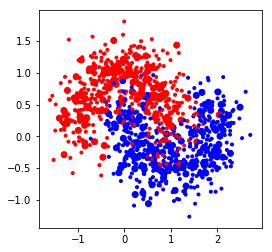

In [2]:
X, y = make_moons(n_samples=1000, noise=0.3, random_state=0)

# for convenience convert labels from {0, 1} to {-1, 1}
y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 30),
                     np.linspace(y_min, y_max, 30))

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

# Plot the training points
plt.figure(figsize=(4, 4))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
plt.scatter(X_test[:, 0], X_test[:, 1], marker='.', c=y_test, cmap=cm_bright)

### Now let us define functions to calculate alphas and distributions for AdaBosot algorithm

In [3]:
def ada_boost_alpha(y, y_pred_t, y_pred_t_1, distribution):
    """
    y_pred_t is a prediction of the t-th base classifier
    y_pred_t_1 is a final boosting prediction at step t-1
    """
    error_t = 0.0
    N = len(y)
    
    for i in range(N):
        if y[i] != y_pred_t[i]:
            error_t += 1 * distribution[i]
    
    alpha = 0.5 * np.log((1 - error_t) / error_t)
    return alpha
    

def ada_boost_distribution(y, y_pred_t, distribution, alpha_t):
    """
    y_pred_t is a prediction of the t-th base classifier
    """
    error_t = 0.0
    N = len(y)
    
    for i in range(N):
        if y[i] != y_pred_t[i]:
            error_t += 1 * distribution[i]
    
    Z_t = 2 * np.sqrt(error_t * (1 - error_t))
    
    for i in range(N):
        distribution[i] = distribution[i] * np.exp(-alpha_t * y_pred_t[i] * y[i]) / Z_t

    return distribution

### Boosting

The code below is an implementation of Boosting class which we will use to construct boosting models.

#### Exercise 1
* Complete fit() and predict() functions.
* The code should be general, i.e. to calculate new alpha you should use self.get_alpha function (it has the same arguments as ada_boost_alpha function)
and to update distribution you should use self.update_distribution function (it has the same arguments as ada_boost_distribution function)

In [6]:
class Boosting():
    """
    Generic class for construction of boosting models
    
    :param n_estimators: int, number of estimators (number of boosting rounds)
    :param base_classifier: callable, a function that creates a weak estimator. Weak estimator should support sample_weight argument
    :param get_alpha: callable, a function, that calculates new alpha given current distribution, prediction of the t-th base estimator,
                      boosting prediction at step (t-1) and actual labels
    :param get_distribution: callable, a function, that calculates samples weights given current distribution, prediction, alphas and actual labels
    """
    def __init__(self, n_estimators=50, base_classifier=None,
                 get_alpha=ada_boost_alpha, update_distribution=ada_boost_distribution):
        self.n_estimators = n_estimators
        self.base_classifier = base_classifier
        self.get_alpha = get_alpha
        self.update_distribution = update_distribution
        
    def fit(self, X, y):
        n_samples = len(X)
        distribution = np.ones(n_samples, dtype
                               =float) / n_samples
        self.classifiers = []
        self.alphas = []
        for i in range(self.n_estimators):
            # create a new classifier
            self.classifiers.append(self.base_classifier())
            # self.classifiers.append(DecisionTreeClassifier(max_depth=1))          
            self.classifiers[-1].fit(X, y, sample_weight=distribution)
            
            if i > 0:
                y_pred_t_1 = self.predict_raw(X)
            else:
                y_pred_t_1 = self.classifiers[-1].predict(X)
            
            y_pred_t = self.classifiers[-1].predict(X)
            alpha_i = self.get_alpha(y, y_pred_t, y_pred_t_1, distribution)
            self.alphas.append(alpha_i)
            
            distribution = self.update_distribution(y, y_pred_t, distribution, alpha_i)
    
    def predict_raw(self, X):
        predictions = np.zeros(X.shape[0])
        N = len(self.classifiers) - 1
        
        for i in range(N):
            predictions += self.classifiers[i].predict(X) * self.alphas[i]
        
        return predictions
        
    
    def predict(self, X):
        final_predictions = np.zeros(X.shape[0])
        
        N = len(self.classifiers) - 1
        
        for i in range(N):
            final_predictions += self.classifiers[i].predict(X) * self.alphas[i]
        
        return np.sign(final_predictions)

### Check your code
Run the following code. It builds a classifier and calcualtes accuracy on the test set.
The accuracy should be the same as of sklearn implementation.

accuracy ada_boost: 0.89625
accuracy ada_boost_sklearn: 0.89875


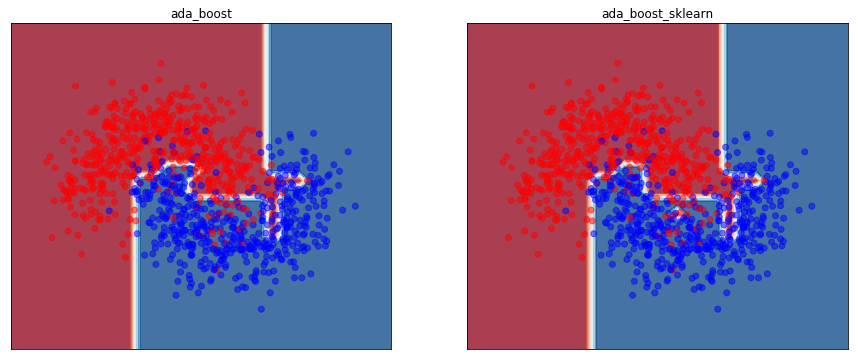

In [5]:
from sklearn.ensemble import AdaBoostClassifier

max_depth = 5
n_estimators = 50

get_base_clf = lambda: DecisionTreeClassifier(max_depth=max_depth)
ada_boost = Boosting(n_estimators=n_estimators,
                     base_classifier=get_base_clf)
ada_boost.fit(X_train, y_train)

ada_boost_sklearn = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),
                                       algorithm="SAMME",
                                       n_estimators=n_estimators)

ada_boost_sklearn.fit(X_train, y_train)

classifiers = [ada_boost, ada_boost_sklearn]
names = ['ada_boost', 'ada_boost_sklearn']

plt.figure(figsize=(15, 6))
# # test ensemble classifier
for i, clf in enumerate(classifiers):
    prediction = clf.predict(X_test)

    # Put the result into a color plot
    ax = plt.subplot(1, len(classifiers), i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, alpha=0.5)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(names[i])

    print('accuracy {}: {}'.format(names[i], (prediction == y_test).sum() * 1. / len(y_test)))

### Other losses
In this part of assignment you will implement boosting with different losses

#### Exercise 2
* Implement function to calculate alpha in case of least squares loss: $\Phi(-u) = (1 - u)^2$
* Implement function to update distribution in case of logloss

In [14]:
def ls_alpha(y, y_pred_t, y_pred_t_1, distribution):
    
    error_t = 0.0
    N = len(y)
    
    for i in range(N):
        if y[i] != y_pred_t[i]:
            error_t += 1 * distribution[i]
    
    alpha = 1 - 2 * error_t
    
    return alpha


def ls_distribution(y, y_pred_t, distribution, alpha_t):
  
    error_t = 0.0
    N = len(y)
    
    for i in range(N):
        if y[i] != y_pred_t[i]:
            error_t += 1 * distribution[i]
            
    Z_t = 4 * error_t * (1 - error_t)
    
    for i in range(N):
        distribution[i] = distribution[i] * (1 - alpha_t * y_pred_t[i] * y[i]) ** 2 / Z_t
     
    return distribution

### Check your code
Run the following code. It builds a classifier and calcualtes accuracy on the test set.
The accuracy is slightly worse than for AdaBoost (with exponential loss).

* Can you say, why least squares loss is worse than exponential loss?

accuracy ada_boost_ls_loss: 0.8775
accuracy ada_boost_exp_loss: 0.8975


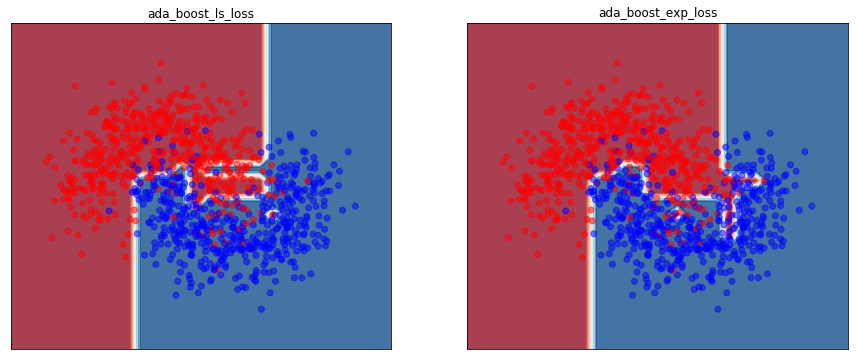

In [34]:
get_base_clf = lambda: DecisionTreeClassifier(max_depth=max_depth)
ada_boost = Boosting(n_estimators=n_estimators,
                     base_classifier=get_base_clf,
                     get_alpha=ls_alpha,
                     update_distribution=ls_distribution)
ada_boost.fit(X_train, y_train)

# test ensemble classifier
prediction = ada_boost.predict(X_test)

classifiers = [ada_boost, ada_boost_sklearn]
names = ['ada_boost_ls_loss', 'ada_boost_exp_loss']

plt.figure(figsize=(15, 6))
# # test ensemble classifier
for i, clf in enumerate(classifiers):
    prediction = clf.predict(X_test)

    # Put the result into a color plot
    ax = plt.subplot(1, len(classifiers), i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, alpha=0.5)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(names[i])

    print('accuracy {}: {}'.format(names[i], (prediction == y_test).sum() * 1. / len(y_test)))

#### Exercise 3
* Implement function to calculate alpha in case of logloss: $\Phi(-x) = \log(1 + e^{-x})$
* Implement function to update distribution in case of logloss

In case of logloss you can't find the optimal alpha analytically, instead we propose to use estimate of optimal alpha
using one Newton step. So, you need to

* Calculate derivative $d_1 = \frac{\partial F(\alpha_{t-1} + \eta e_t)}{\partial \eta}$ at $\eta = 0$.
* Calculate the second derivative $d_2 = \frac{\partial^2 F(\alpha_{t-1} + \eta e_t)}{\partial \eta^2}$ at $\eta = 0$.
* The estimate of the alpha is $\alpha_t \approx -\frac{d_1}{d_2}$

In [8]:
def logloss_alpha(y, y_pred_t, y_pred_t_1, distribution):
    
    N = len(y)
    d1 = 0
    d2 = 0
    
    for i in range(N):
        d1 += (-y[i] * y_pred_t[i] * np.exp(-y[i] * y_pred_t_1[i])) /( 1 + np.exp(-y[i] * y_pred_t_1[i]))
        d2 += ((y[i] * y_pred_t[i]) ** 2 * np.exp(-y[i] * y_pred_t_1[i])) / (1 + np.exp(-y[i] * y_pred_t_1[i]))
        d2 -= ((y[i] * y_pred_t[i]) ** 2 * np.exp(-2 * y[i] * y_pred_t_1[i])) / (1 + np.exp(-y[i] * y_pred_t_1[i])) ** 2
    
    alpha = - d1 / d2
    return alpha


def logloss_distribution(y, y_pred_t, distribution, alpha_t):
    
    error_t = 0.0
    N = len(y)
    
    for i in range(N):
        if y[i] != y_pred_t[i]:
            error_t += 1 * distribution[i]
            
    Z_t =  (1 - error_t) * np.log(1 + np.exp( - alpha_t)) + error_t * np.log(1 + np.exp(alpha_t))
    
    for i in range(N):
        distribution[i] = distribution[i] * np.log((1 + np.exp(-alpha_t * y_pred_t[i] * y[i]))) / Z_t
        
    return distribution

accuracy ada_boost_logloss: 0.9075
accuracy ada_boost_exp_loss: 0.89875


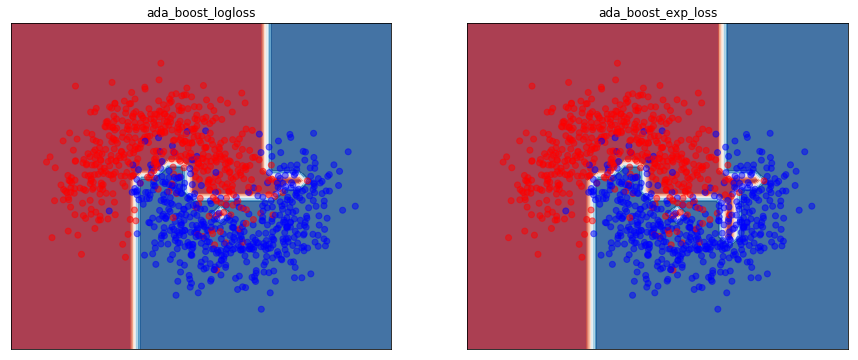

In [11]:
get_base_clf = lambda: DecisionTreeClassifier(max_depth=max_depth)
ada_boost = Boosting(n_estimators=n_estimators,
                     base_classifier=get_base_clf,
                     get_alpha=logloss_alpha,
                     update_distribution=logloss_distribution)
ada_boost.fit(X_train, y_train)

# test ensemble classifier
prediction = ada_boost.predict(X_test)

classifiers = [ada_boost, ada_boost_sklearn]
names = ['ada_boost_logloss', 'ada_boost_exp_loss']

plt.figure(figsize=(15, 6))
# # test ensemble classifier
for i, clf in enumerate(classifiers):
    prediction = clf.predict(X_test)

    # Put the result into a color plot
    ax = plt.subplot(1, len(classifiers), i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, alpha=0.5)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(names[i])

    print('accuracy {}: {}'.format(names[i], (prediction == y_test).sum() * 1. / len(y_test)))